In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
100168,00026546_001.png,Effusion|Infiltration,1,26546,32,F,PA,2992,2991,0.143,0.143,NaN
86402,00021303_001.png,No Finding,1,21303,56,M,PA,2992,2991,0.143,0.143,NaN
78794,00019345_000.png,No Finding,0,19345,44,F,PA,2992,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4075,00020094_005.png,Infiltration,5,20094,044Y,M,PA,3056,2528,0.139,0.139
3122,00015388_003.png,No Finding,3,15388,017Y,M,PA,2048,2500,0.168,0.168
1905,00009993_000.png,No Finding,0,9993,044Y,F,AP,2500,2048,0.168,0.168


There is a difference between the "Data_Entry_2017.csv" and "sample_labels": 
* Patient Age: has Y, M and D ( Year, Month and days) in the end
* No Unnamed Column

### Analysis of the Metadata

In [4]:
df = all_xray_df.copy()

In [5]:
## EDA
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


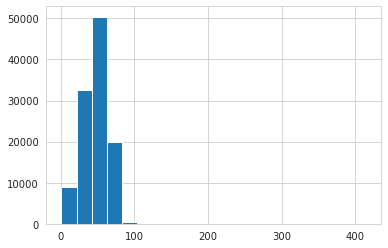

In [6]:
df['Patient Age'].hist(bins=20)

##### There are few patients above 100 years old. 

In [7]:
df[df['Patient Age'] > 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN


##### The age range from 148 to 412. It seems to be a mistake. We can remove these patients

In [8]:
df = df[df['Patient Age'] <= 100]

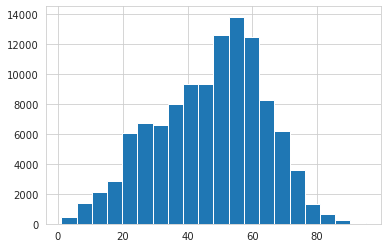

In [9]:
df['Patient Age'].hist(bins=20)

##### Most of the patients are above 40 years old.

### Gender

In [10]:
df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

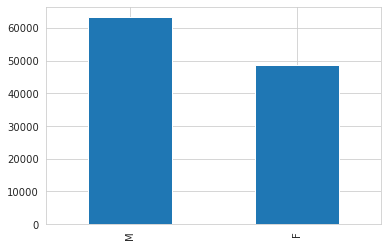

In [11]:
df['Patient Gender'].value_counts().plot(kind = 'bar')

##### There are more male patients than females with 63328 male patients vs 48776 female patients

### View Position

In [12]:
df['View Position'].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

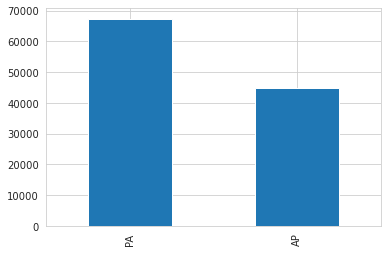

In [13]:
df['View Position'].value_counts().plot(kind = 'bar')

In [14]:
df['Follow-up #'].value_counts()

0      30797
1      13301
2       9186
3       7088
4       5759
       ...  
181        1
174        1
180        1
178        1
173        1
Name: Follow-up #, Length: 184, dtype: int64

In [15]:
df['Follow-up #'].max()

183

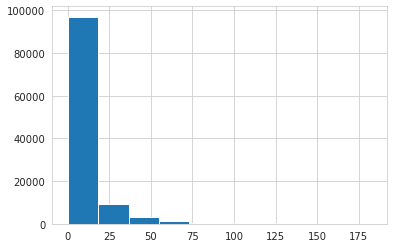

In [16]:
df['Follow-up #'].hist(bins=10)

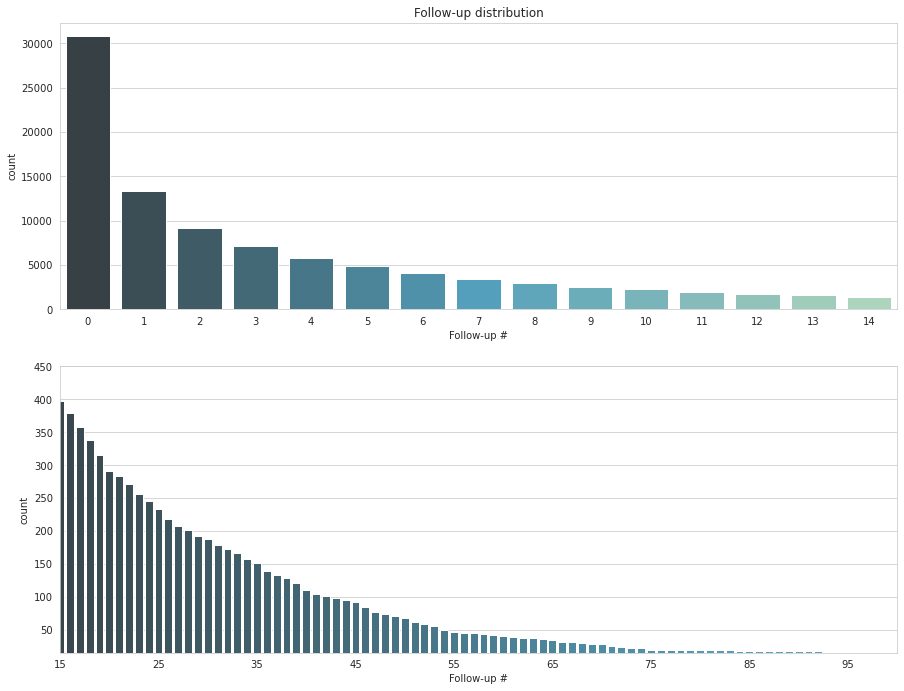

In [17]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

data = df[df['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=data,palette="GnBu_d",ax=ax1);

ax1.set_title('Follow-up distribution');
data = df[df['Follow-up #']>14]
g = sns.countplot(x='Follow-up #',data=data,palette="GnBu_d",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

##### Most of the follow up numbers is 0 at 30805. Hence, it is the first visit of the patient. Followed y the second vist at 13302. The maximum number of visits is 183

In [18]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [19]:
df['Patient ID'].nunique()

30802

##### Number of usinque patients after data cleaning is 30802

In [20]:
df['Finding Labels'].unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

In [21]:
df['Finding Labels'].nunique()

836

##### Some of the patients have multiple diagnosis associated to them

In [22]:
df[df['Finding Labels'] == 'No Finding'].shape

(60353, 12)

##### 60353 patients have no findings

## Following EDA's code is from this notebook shared at Kaggle:
* https://www.kaggle.com/sbernadac/lung-deseases-data-analysis

In [23]:
#Select only few columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    df[pathology] = df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

In [24]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
df.loc[df['Patient ID']==5567,['Patient Age','Finding Labels','Follow-up #']].sort_values('Follow-up #',ascending=True)
df.loc[df['Patient ID']==5567,['Patient Age','Finding Labels','Follow-up #']].sort_values('Patient Age',ascending=False)

,Patient Age,Finding Labels,Follow-up #
20859,57,Fibrosis,7
20860,57,Fibrosis,8
20861,57,No Finding,9
20856,54,Atelectasis,4
20857,54,Atelectasis,5
20858,54,No Finding,6
20853,53,Effusion,1
20854,53,Atelectasis|Effusion|Pneumonia,2
20876,53,Atelectasis|Consolidation,24
20877,53,Pneumonia,25


### Display number of each disease by patient gender

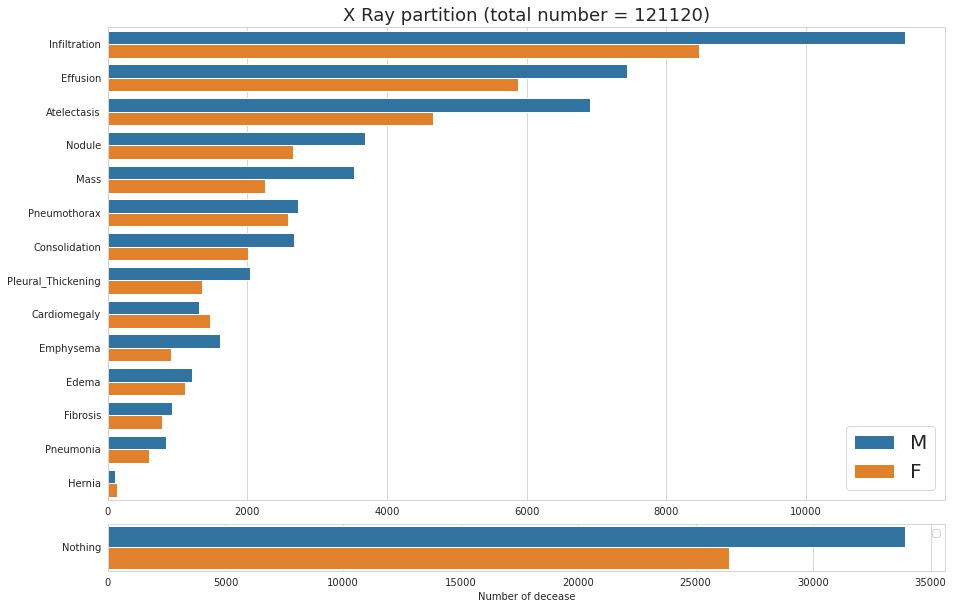

In [26]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

df['Nothing']=df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(df,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)



### age distribution by sex:

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


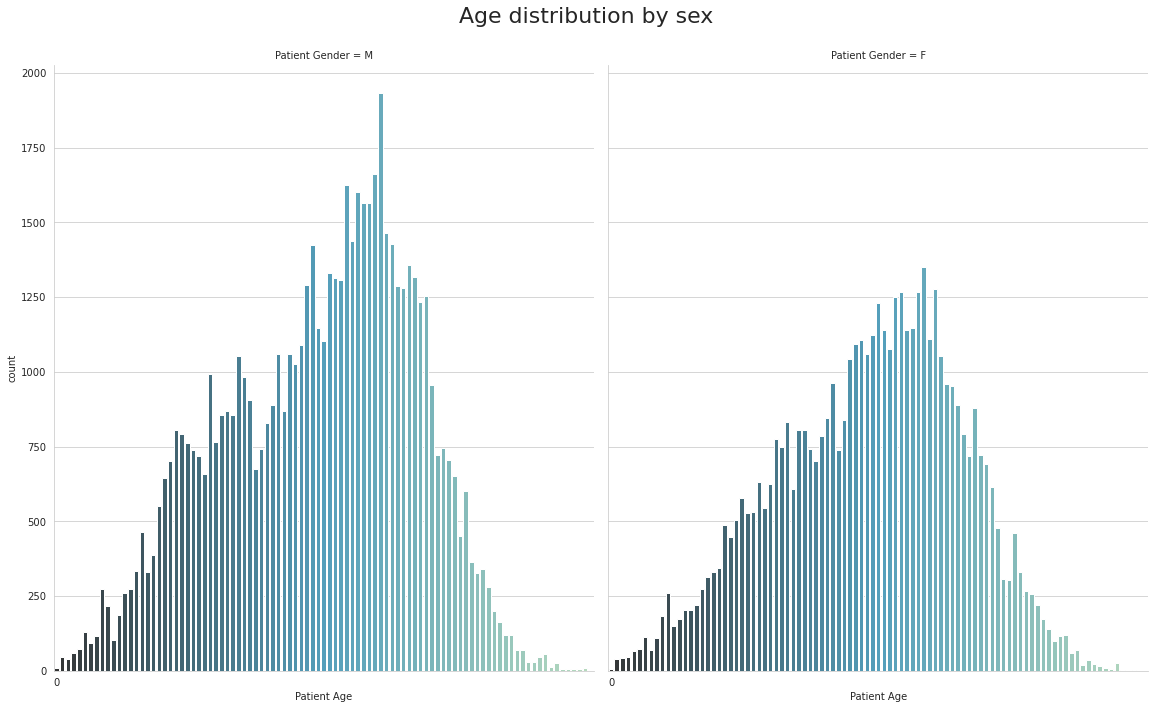

In [27]:
g = sns.factorplot(x="Patient Age", col="Patient Gender",data=df, kind="count",size=10, aspect=0.8,palette="GnBu_d");
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution by sex',fontsize=22);
g.fig.subplots_adjust(top=.9)

### Display pathologies distribution by age&sex.

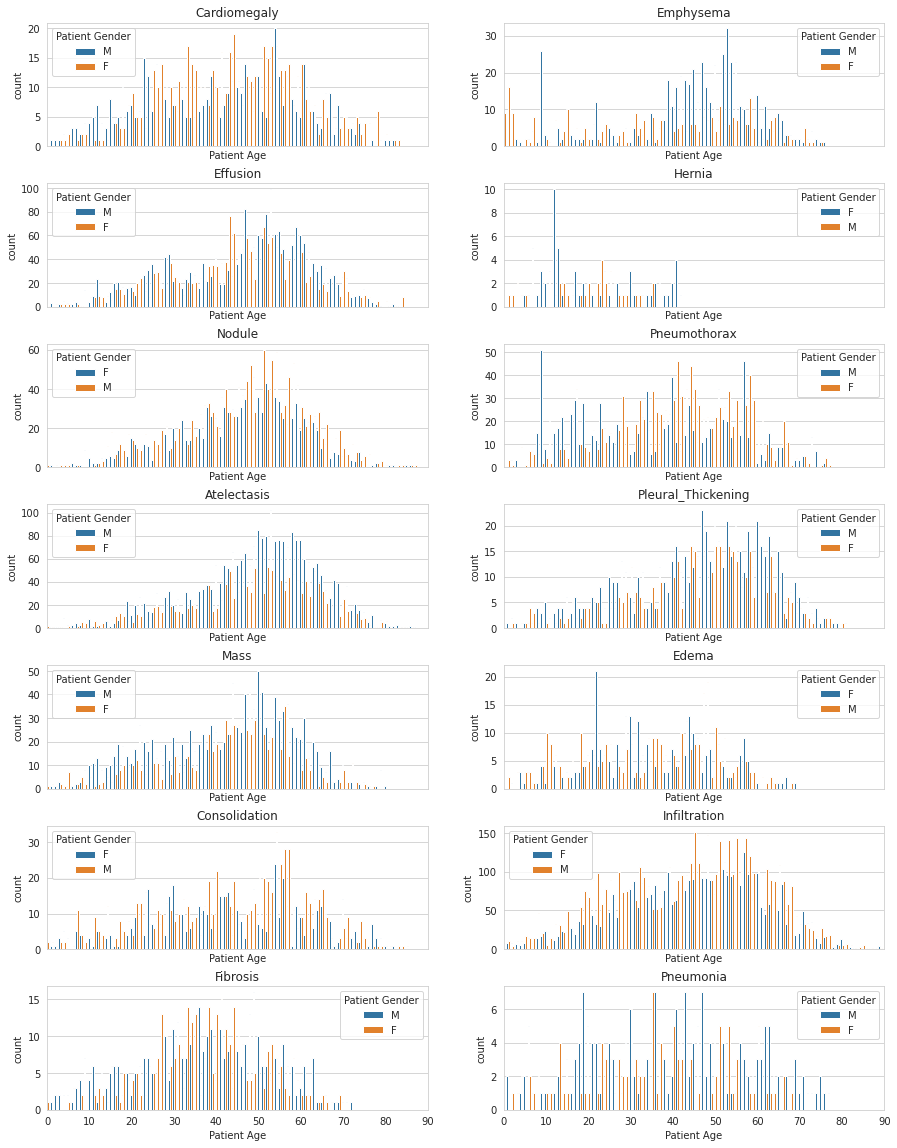

In [28]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df[df['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

### Links between pathologies. 

In [29]:
#First display Top 10 multiple deseases
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False).head(23)
data=data[['|' in index for index in data.index.values]]
data

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,Nothing
Finding Labels,,,,,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603,1603
Atelectasis|Infiltration,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350,1350
Atelectasis|Effusion,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165,1165
Infiltration|Nodule,829,829,829,829,829,829,829,829,829,829,829,829,829,829,829,829,829,829,829,829
Atelectasis|Effusion|Infiltration,737,737,737,737,737,737,737,737,737,737,737,737,737,737,737,737,737,737,737,737
Cardiomegaly|Effusion,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484,484
Consolidation|Infiltration,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441
Infiltration|Mass,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418,418
Effusion|Pneumothorax,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403,403


### Compare ratio between simple and multiple deseases

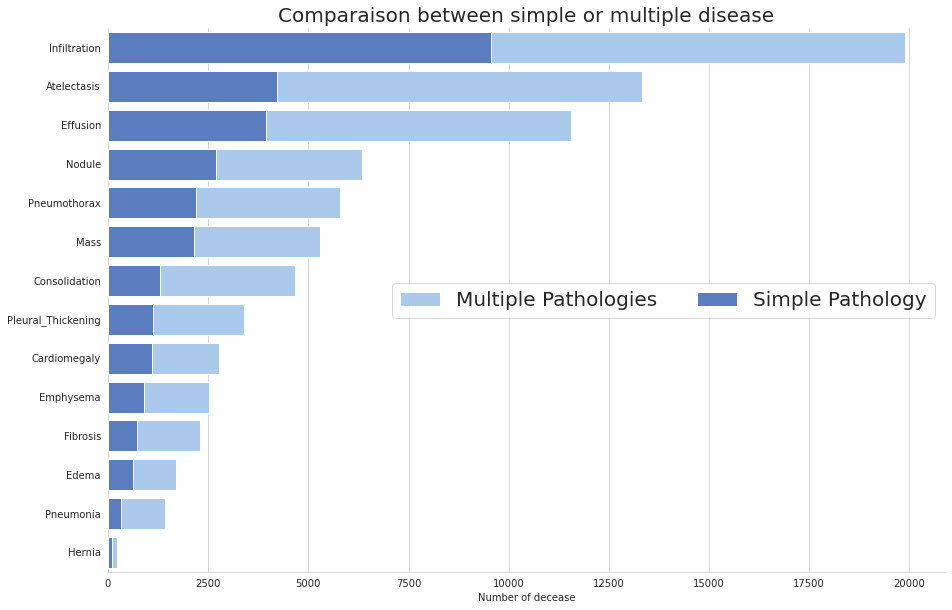

In [30]:
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple disease",fontsize=20)      
sns.despine(left=True)

### Plot most important pathologies groups for each disease

In [31]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head()

,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
Finding Labels,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,Effusion|Infiltration,0,0,1603,0,0,0,0,0,0,0,0,1603,0,0
Atelectasis|Infiltration,1350,Atelectasis|Infiltration,0,0,0,0,0,0,1350,0,0,0,0,1350,0,0
Atelectasis|Effusion,1165,Atelectasis|Effusion,0,0,1165,0,0,0,1165,0,0,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,0,0,829,0,0,0,0,0,0,829,0,0
Atelectasis|Effusion|Infiltration,737,Atelectasis|Effusion|Infiltration,0,0,737,0,0,0,737,0,0,0,0,737,0,0


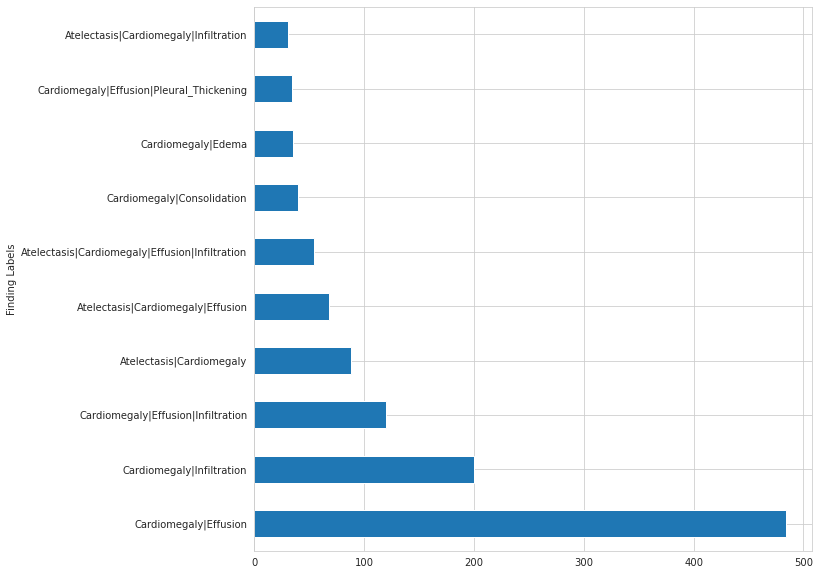

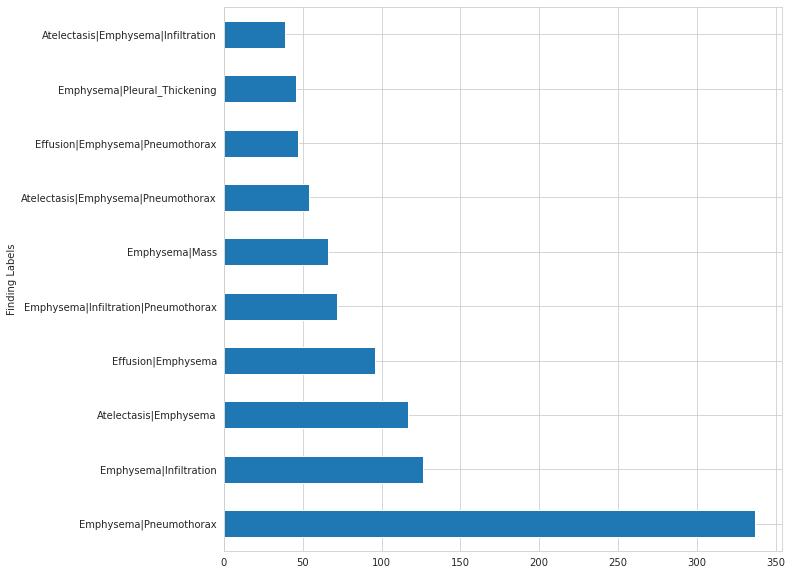

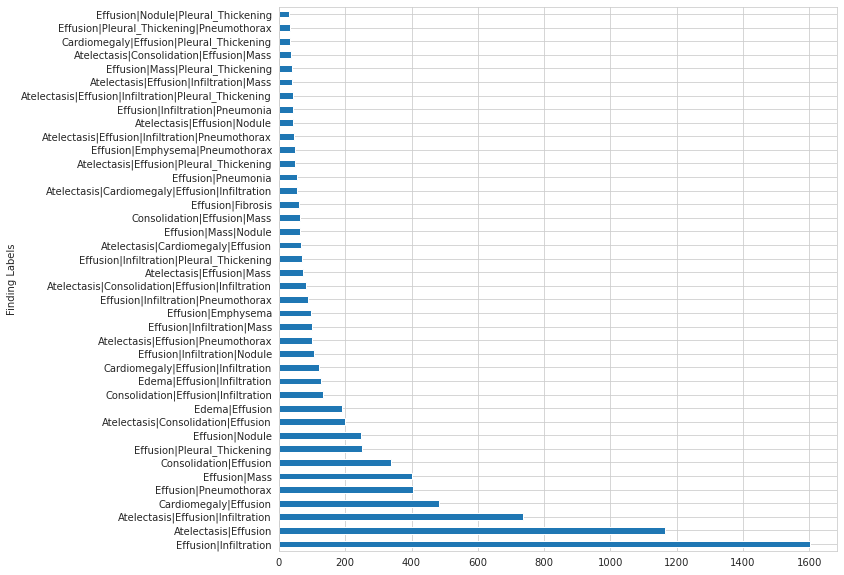

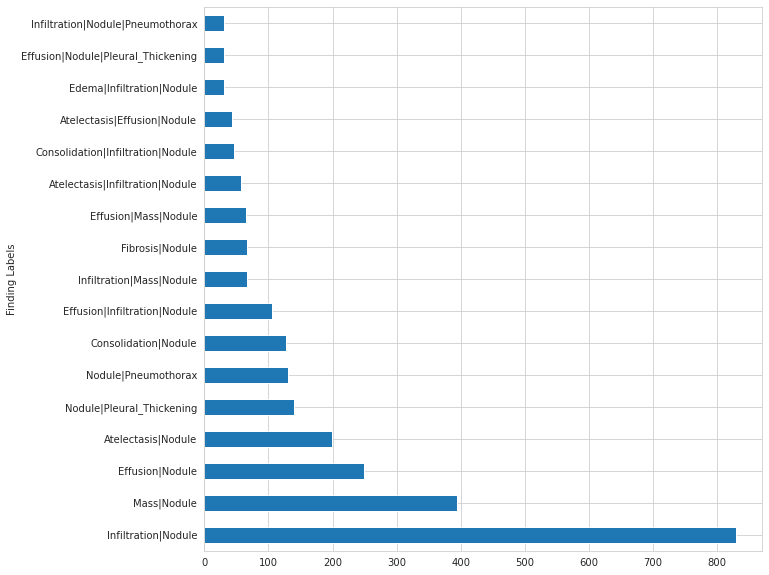

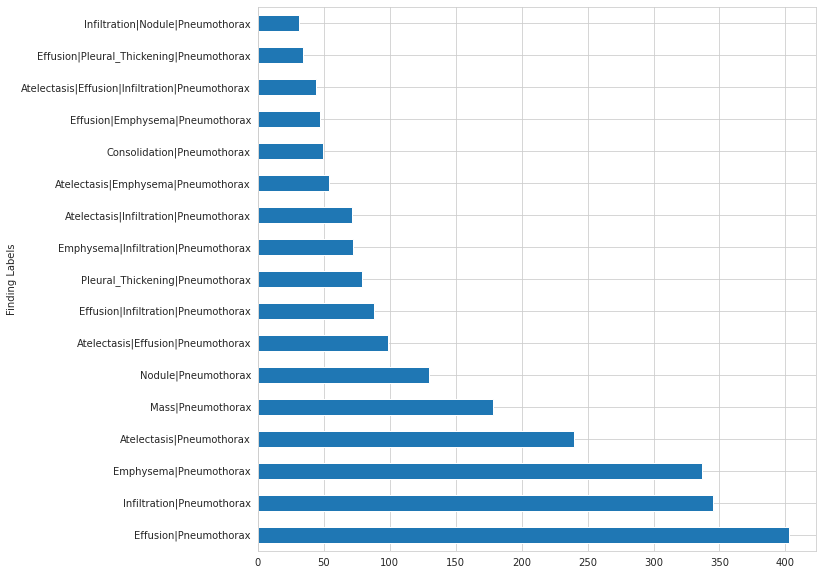

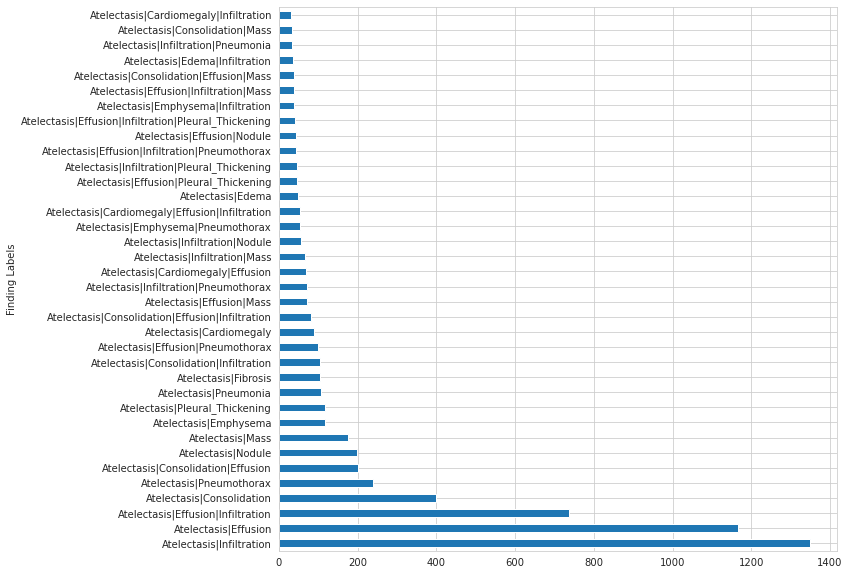

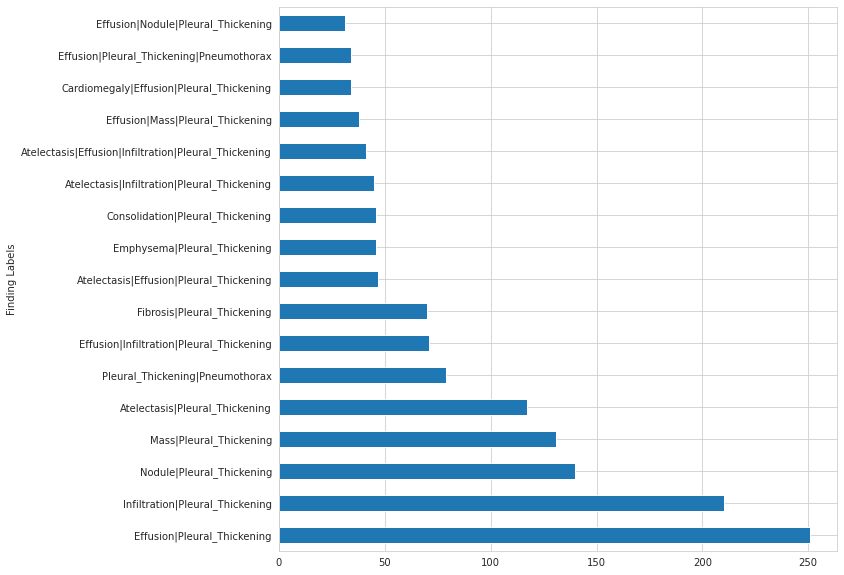

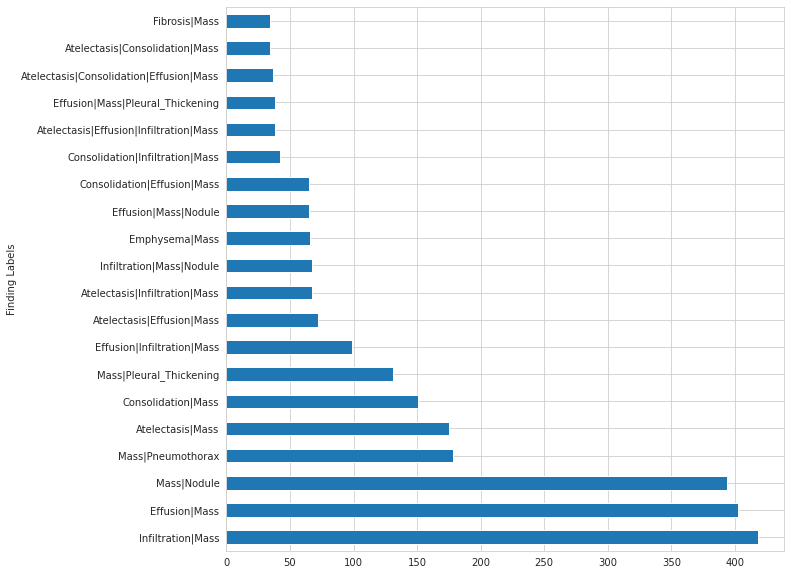

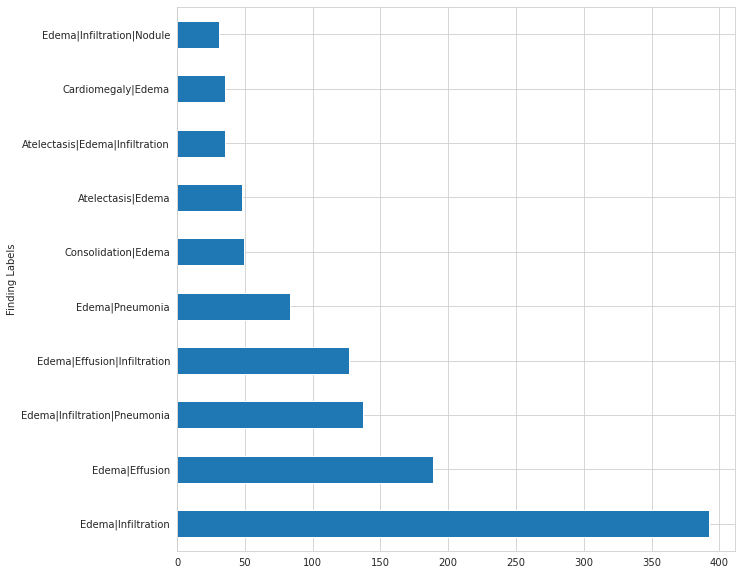

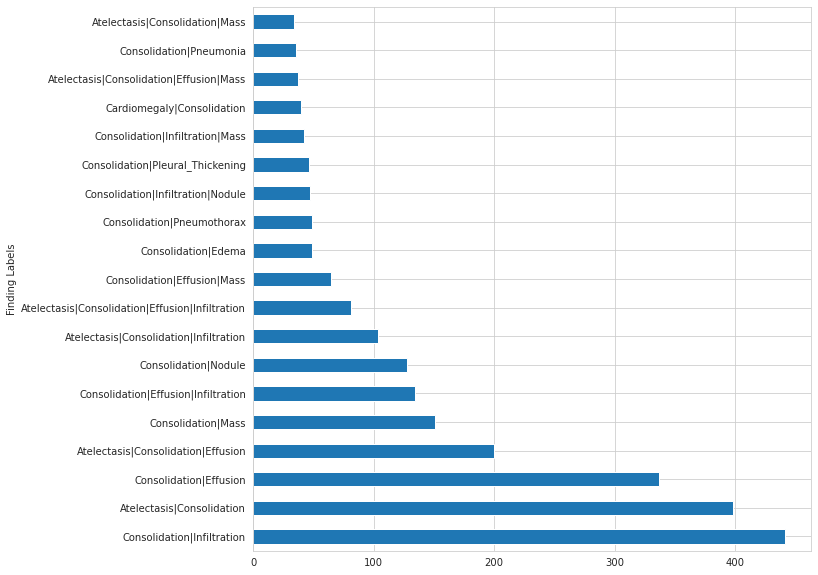

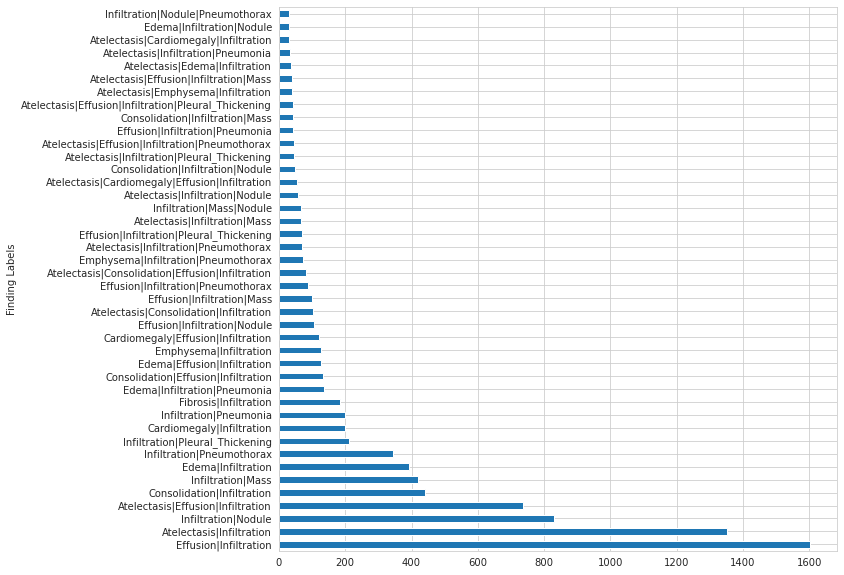

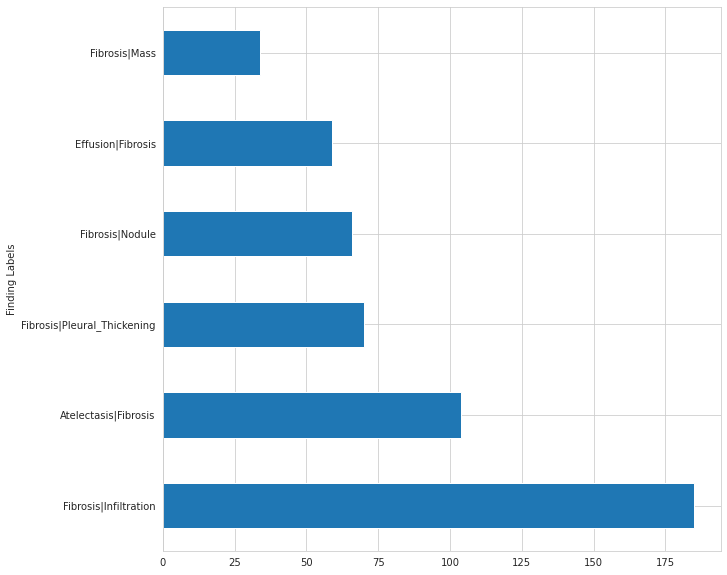

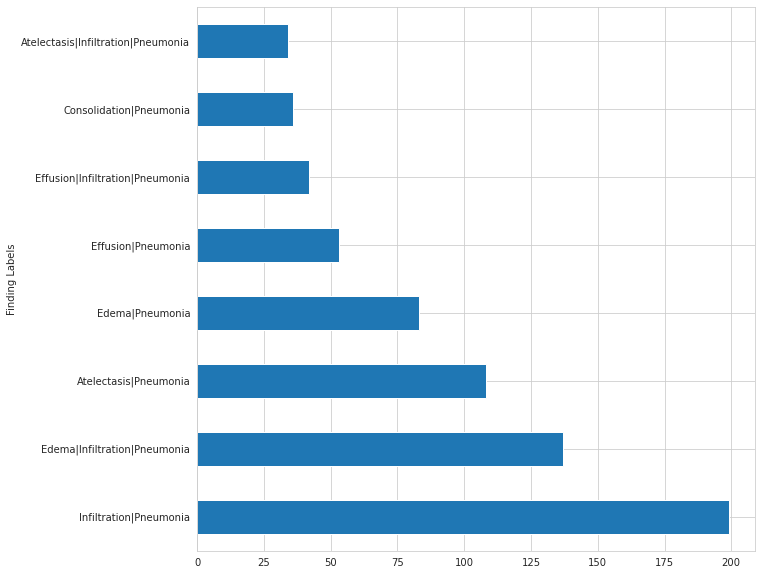

In [32]:
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]
for pathology in pat_list:
    f = plt.subplots(figsize=(10, 10))
    df3[pathology][df3[pathology] >0].plot(kind = 'barh')

##### We can see that some diagnosis seem to appear with all kind of diagnosis:

* Effusion
* Aletectasis
* Infiltration Some others seem to have favorite couple:
* Cardiomegaly with Effusion
* Emphysema with Pneumothorax
* Nodule with Infiltration
* Edema with Infiltration
* Fibrosis with Infiltration
* Pneumonia with Infiltration

'Hernia' has not enough values to figure here

## Pixel Wise Analysis

In [33]:
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia','No Finding']

for pathology in pathology_list :
    sample_df[pathology] = sample_df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)


In [34]:
sample_paths={os.path.basename(x): x for x in glob(os.path.join('/data','images*','*','*.png'))}
sample_df['path']=sample_df['Image Index'].map(sample_paths.get)

In [35]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Finding,path
4865,00025561_009.png,No Finding,9,25561,051Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,/data/images_011/images/00025561_009.png
1984,00010373_000.png,Infiltration,0,10373,014Y,M,PA,2374,2669,0.143,...,0,0,0,0,0,1,0,0,0,/data/images_005/images/00010373_000.png
3260,00016086_002.png,Effusion|Mass,2,16086,060Y,M,PA,2992,2991,0.143,...,0,0,1,0,0,0,0,0,0,/data/images_008/images/00016086_002.png


In [36]:
pneumonia_df =sample_df[sample_df['Pneumonia']==1]
no_finding_df=sample_df[sample_df['No Finding']==1]

### Pneumonia Images

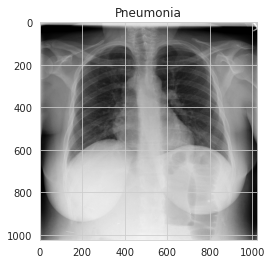

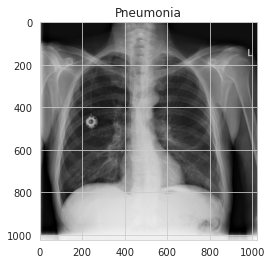

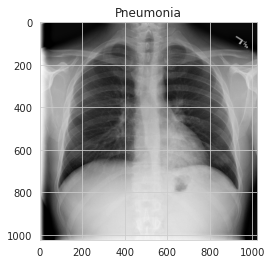

In [37]:
for image  in pneumonia_df ['path'].sample(3):
    plt.figure()
    plt.imshow(plt.imread(image), cmap = 'gray')
    plt.title('Pneumonia')
    plt.show()
    

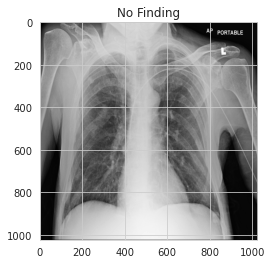

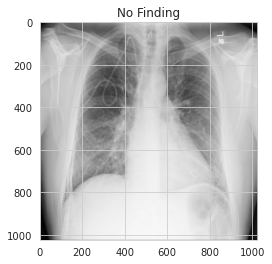

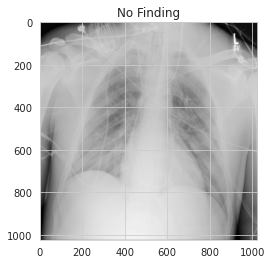

In [38]:
for image  in no_finding_df['path'].sample(3):
    plt.figure()
    plt.imshow(plt.imread(image), cmap = 'gray')
    plt.title('No Finding')
    plt.show()

### Looking at intensities

In [39]:
#plt.hist(plt.imread(pneumonia_df['path'].iloc[20]).reshape(1,-1)[0], bins = 256);


### Some random selections

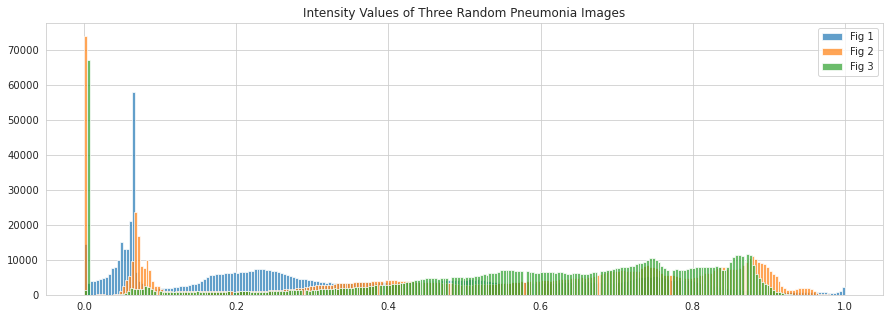

In [40]:
pne_1=plt.imread(pneumonia_df['path'].iloc[20]).ravel()
pne_2=plt.imread(pneumonia_df['path'].iloc[2]).ravel()
pne_3=plt.imread(pneumonia_df['path'].iloc[30]).ravel()

plt.figure(figsize=(15,5))
plt.hist(pne_1,bins=256,alpha=0.7, label='Fig 1')
plt.hist(pne_2,bins=256,alpha=0.7, label='Fig 2')
plt.hist(pne_3,bins=256,alpha=0.7, label='Fig 3')
plt.legend(loc='upper right')
plt.title('Intensity Values of Three Random Pneumonia Images')
plt.show()



##### Note the peak at zero, which are background pixels. This distribution makes it seem like the mean intensity is probably around 140, but let's find out for sure:


#### Find the mean and std dev intensity values of the image, and standerdize it

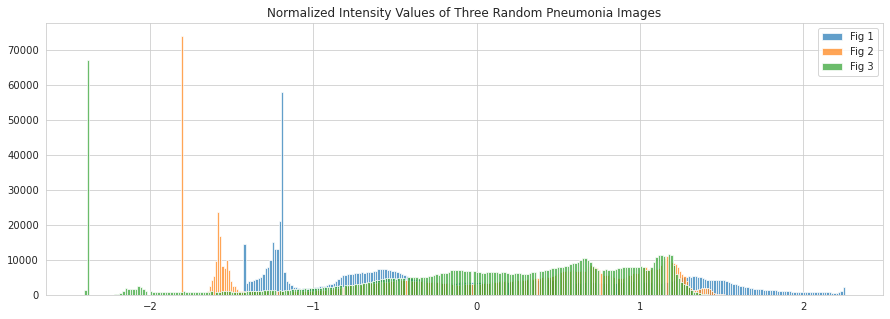

In [41]:
new_image_1=(pne_1-np.mean(pne_1))/np.std(pne_1)
new_image_2=(pne_2-np.mean(pne_2))/np.std(pne_2)
new_image_3=(pne_3-np.mean(pne_3))/np.std(pne_3)
plt.figure(figsize=(15,5))
plt.hist(new_image_1,bins=256,alpha=0.7, label='Fig 1')
plt.hist(new_image_2,bins=256,alpha=0.7, label='Fig 2')
plt.hist(new_image_3,bins=256,alpha=0.7, label='Fig 3')
plt.legend(loc='upper right')
plt.title('Normalized Intensity Values of Three Random Pneumonia Images')
plt.show()

##### Notice how the histogram has the same shape, but now it's centered around 0. This is a key step in image pre-processing when we prepare imaging data for machine learning. 

It tell us that the intensity values of the mass are higher than the image mean, but mostly fall within two standard deviation of the image intensity values. This tell us that using some sort of thresholding mechanism to identify tumors in an image would probably not be appropriate, because the mass's intensity values are not that different from the rest of the image. 

In [42]:
sample_pne_intensities = []
for i in pneumonia_df['path'].sample(40):     
    img = plt.imread(i)
    sample_pne_intensities.extend(img.ravel())
    
sample_no_findings_intensities = []
for i in no_finding_df['path'].sample(40):     
    img = plt.imread(i)
    sample_no_findings_intensities.extend(img.ravel())

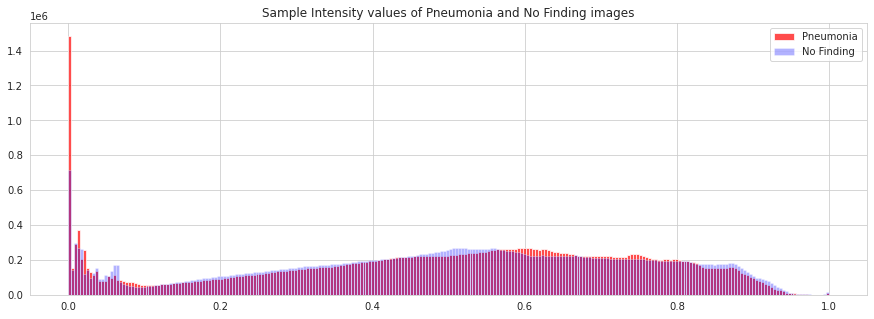

In [43]:
plt.figure(figsize=(15,5))
plt.hist(sample_pne_intensities,bins=256,alpha=0.7, label='Pneumonia', color = 'red')
plt.hist(sample_no_findings_intensities,bins=256,alpha=0.3, label='No Finding', color = 'blue')
plt.legend(loc='upper right')
plt.title('Sample Intensity values of Pneumonia and No Finding images')
plt.show()

##### There not much difference intensity values distribution between pneumonia and no finding images. 

### Normalized

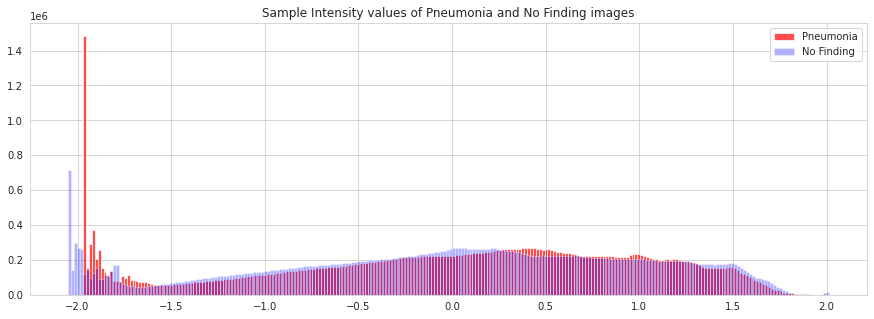

In [44]:
new_image_pne=(sample_pne_intensities-np.mean(sample_pne_intensities))/np.std(sample_pne_intensities)
new_image_none=(sample_no_findings_intensities-np.mean(sample_no_findings_intensities))/np.std(sample_no_findings_intensities)
plt.figure(figsize=(15,5))
plt.hist(new_image_pne,bins=256,alpha=0.7, label='Pneumonia', color = 'red')
plt.hist(new_image_none,bins=256,alpha=0.3, label='No Finding', color = 'blue')
plt.legend(loc='upper right')
plt.title('Sample Intensity values of Pneumonia and No Finding images')
plt.show()

##### Still not much difference. Hence, pixel value distribution is not a good feauture for classifying pneumonia.